In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Shared_ADA/

# Useful Imports

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import string
from scipy.ndimage.filters import gaussian_filter1d
from helpers import *
from tqdm import tqdm
from datetime import *

# Imports we will use for Bert model for sentiment analysis

try:
  from transformers import AutoModelForSequenceClassification, AutoTokenizer,AutoModelForTokenClassification
except:
  !pip install transformers
  from transformers import AutoModelForSequenceClassification, AutoTokenizer,AutoModelForTokenClassification

import torch
from torch.utils.data import IterableDataset, DataLoader

import json
import csv

# Data Analysis

## Basic statstics

This section will mainly show how are our data points spread over time to see how can conclusions be drawn.

In [14]:
df_bitcoin = pd.read_csv('./Data/bitcoin_data.csv')
df_bitcoin.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2015-10-04-032770,Litecoin Shows There Is a Simple Fix for Spam ...,Charlie Lee,"['Q2960866', 'Q357856', 'Q50326813', 'Q55607117']",2015-10-04 18:48:44,1,"[['Charlie Lee', '0.9254'], ['None', '0.0746']]",['http://cointelegraph.com/news/115374/the-ong...,E
1,2015-09-15-114302,We believe that you deserve to reap the benefi...,Vishal Gupta,['Q57623555'],2015-09-15 20:32:32,1,"[['Vishal Gupta', '0.5501'], ['None', '0.2781'...",['http://benzinga.com/news/15/09/5835310/bitco...,E
2,2015-02-06-003563,AmEx needs to get into Bitcoin or one of the o...,Porter Bibb,['Q7231593'],2015-02-06 21:39:00,2,"[['Porter Bibb', '0.8712'], ['None', '0.1288']]",['http://us.rd.yahoo.com/finance/external/inve...,E
3,2015-06-22-017667,If each bitcoin has a history and people know ...,Greg Maxwell,['Q46997142'],2015-06-22 14:45:56,1,"[['Greg Maxwell', '0.966'], ['None', '0.034']]",['http://www.newsbtc.com/2015/06/22/how-blocks...,E
4,2015-10-07-012201,Bitcoin in its current incarnation is slow in ...,Ann Cairns,['Q28870363'],2015-10-07 17:02:57,1,"[['Ann Cairns', '0.8585'], ['None', '0.1415']]",['http://cointelegraph.com/news/115390/masterc...,E


We start by adding time columns which will be useful to compartmentalize data over time for further analysis and pattern recognition.

In [16]:
df_bitcoin['month'] = pd.to_datetime(df_bitcoin['date']).dt.to_period('M')
df_bitcoin['day'] = pd.to_datetime(df_bitcoin['date']).dt.to_period('D')
df_bitcoin['year'] = pd.to_datetime(df_bitcoin['date']).dt.to_period('Y')
df_bitcoin['month_nb'] = pd.to_datetime(df_bitcoin['date']).dt.month

In [17]:
df_time = df_bitcoin.groupby('month')['quotation'].count()
df_time = pd.DataFrame(df_time).rename(columns={'quotation':'count'}).reset_index()
df_time['month'] = df_time['month'].apply(lambda x : x.to_timestamp())
df_time['month'] = pd.to_datetime(df_time['month'])
fig = go.Figure(data=[go.Bar(x=df_time['month'],y=df_time['count'], marker_color='lightslategrey')])
fig.update_layout(
  title="Number of bitcoin quotations over 2015-2020 period in the Quotebank dataset",
  xaxis_title="Date",
  yaxis_title="Number of quotes",
  )
fig.show()

## Basis stastics about speakers

When we talk about a subject as serious as bitcoin and crypto in general, the identity of the speaker is as important as the quote itself, so it's only natural to see how is data distributed over speakers over time. 
<br> In this subsection we first analyse the amount of data to see who are the most important and potentially influential speakers. Later on, we will leverage this information to analyse the behaviour and the feeling of these speakers independetly to make the best out of it.

In [19]:
speakers = df_bitcoin['probas'].apply(lambda x: split_speakers(x))

# Take only the most probable speaker of each quote
most_likely_speakers = speakers.apply(lambda x: x[0])
counts_most_likely = most_likely_speakers.value_counts()

# A new column of the most likely speaker so that we can groupby them if necessary
df_bitcoin['most_likely_speaker'] = most_likely_speakers

In [20]:
counts_most_likely[1:10]

Tom Lee         303
Jamie Dimon     189
Roger Ver       184
Tim Draper      161
Craig Wright    157
Brian Kelly     150
Charlie Lee     149
Bobby Lee       148
Jack Dorsey     145
Name: probas, dtype: int64

Distribution of quotations about bitcoin over most influential speakers during the 2015-2020 period.

In [21]:
plot_count_speaker(['Tom Lee', 'Craig Wright', 'Roger Ver', 'Jamie Dimon'], df_bitcoin)

## Data Preprocessing

This section is about preprocessing data, in particular textual data (quotations). In order to make the best out of the sentiment analysis algorithm, we wanted to normalize data by lemmatizing it. We didn't apply other modifications as lowering, removing stopewords ... because Bert algorithm takes these into account to determine the sentiment.

In [22]:
df_lemmatized = process(df_bitcoin)
df_lemmatized.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,month,day,year,month_nb,most_likely_speaker
0,2015-10-04-032770,Litecoin Shows There Is a Simple Fix for Spam ...,Charlie Lee,"['Q2960866', 'Q357856', 'Q50326813', 'Q55607117']",2015-10-04 18:48:44,1,"[['Charlie Lee', '0.9254'], ['None', '0.0746']]",['http://cointelegraph.com/news/115374/the-ong...,E,2015-10,2015-10-04,2015,10,Charlie Lee
1,2015-09-15-114302,We believe that you deserve to reap the benefi...,Vishal Gupta,['Q57623555'],2015-09-15 20:32:32,1,"[['Vishal Gupta', '0.5501'], ['None', '0.2781'...",['http://benzinga.com/news/15/09/5835310/bitco...,E,2015-09,2015-09-15,2015,9,Vishal Gupta
2,2015-02-06-003563,AmEx need to get into Bitcoin or one of the ot...,Porter Bibb,['Q7231593'],2015-02-06 21:39:00,2,"[['Porter Bibb', '0.8712'], ['None', '0.1288']]",['http://us.rd.yahoo.com/finance/external/inve...,E,2015-02,2015-02-06,2015,2,Porter Bibb
3,2015-06-22-017667,If each bitcoin ha a history and people know h...,Greg Maxwell,['Q46997142'],2015-06-22 14:45:56,1,"[['Greg Maxwell', '0.966'], ['None', '0.034']]",['http://www.newsbtc.com/2015/06/22/how-blocks...,E,2015-06,2015-06-22,2015,6,Greg Maxwell
4,2015-10-07-012201,Bitcoin in it current incarnation is slow in t...,Ann Cairns,['Q28870363'],2015-10-07 17:02:57,1,"[['Ann Cairns', '0.8585'], ['None', '0.1415']]",['http://cointelegraph.com/news/115390/masterc...,E,2015-10,2015-10-07,2015,10,Ann Cairns


## Sentiment Analysis

Bert algorithm is one of our main focuses in this project, it will allow us to determine if there exists some pattern linking  some important people's opinion about bitcoin to the volume/price eventual changes, as well as bear and bullish markets occurences.
<br> Hence, we start by apllying the trained Bert model which compares two sentences to our quotations: to test people sentiment about bitcoin, we see how each quotation is "near" or "far" from the sentences "The sentiment about bitcoin is positive" and "The sentiment about bitcoin is negative" which tells us if the sentiment is indeed positive or negative (based on a score).
<br> Later on, we will explore another algotrithm which does sentiment analysis too but in an aspect based manner.

In [ ]:
nli_model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli',output_attentions=True).cuda()
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
statements = df_lemmatized['quotation']

with torch.no_grad():
  positives = []
  negatives = []

  for statement in tqdm(statements):
      for sentiment in ['positive','negative']:
        hypothesis = 'The sentiment about bitcoin is {}.'.format(sentiment)
        x = tokenizer.encode(statement, hypothesis,return_tensors='pt',truncation_strategy='only_first')
        out=nli_model(x.cuda())
        logits = out[0]
        entail_contradiction_logits = logits[:,[0,2]]
        probs = entail_contradiction_logits.softmax(dim=1)
        prob_label_is_true = probs[:,1]
        if sentiment == 'positive':
          positives.append(prob_label_is_true.item())
        else:
          negatives.append(prob_label_is_true.item())

  0%|          | 0/20109 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2254: FutureWarning:

The `truncation_strategy` argument is deprecated and will be removed in a future version, use `truncation=True` to truncate examples to a max length. You can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to truncate to the maximal input size of the model (e.g. 512 for Bert).  If you have pairs of inputs, you can give a specific truncation strategy selected among `truncation='only_first'` (will only truncate the first sentence in the pairs) `truncation='only_second'` (will only truncate the second sentence in the pairs) or `truncation='longest_first'` (will iteratively remove tokens from the longest sentence in the pairs).

100%|██████████| 20109/20109 [42:41<00:00,  7.85it/s]


Add the columns of sentiment score to the dataframe.

In [ ]:
df_lemmatized['positive_score_btc'] = positives
df_lemmatized['negative_score_btc'] = negatives

In [ ]:
df_lemmatized.to_csv('./Data/score_btc.csv', index=False)

### Visualization and comparison with greed/fear index

This section treats about a metric that will very likely be our main sanity check index as we took from an online dataset. It gives who much are people greedy or fearful concerning bitcoin at a certain point of point, which is obvisouly related to our sentiment analysis problem over quotes.

In [26]:
df_lemmatized = pd.read_csv('./Data/score_btc.csv')
df_lemmatized.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,month,day,year,month_nb,most_likely_speaker,positive_score_btc,negative_score_btc
0,2015-10-04-032770,Litecoin Shows There Is a Simple Fix for Spam ...,Charlie Lee,"['Q2960866', 'Q357856', 'Q50326813', 'Q55607117']",2015-10-04 18:48:44,1,"[['Charlie Lee', '0.9254'], ['None', '0.0746']]",['http://cointelegraph.com/news/115374/the-ong...,E,2015-10,2015-10-04,2015,10,Charlie Lee,0.052878,0.104096
1,2015-09-15-114302,We believe that you deserve to reap the benefi...,Vishal Gupta,['Q57623555'],2015-09-15 20:32:32,1,"[['Vishal Gupta', '0.5501'], ['None', '0.2781'...",['http://benzinga.com/news/15/09/5835310/bitco...,E,2015-09,2015-09-15,2015,9,Vishal Gupta,0.303506,0.000175
2,2015-02-06-003563,AmEx need to get into Bitcoin or one of the ot...,Porter Bibb,['Q7231593'],2015-02-06 21:39:00,2,"[['Porter Bibb', '0.8712'], ['None', '0.1288']]",['http://us.rd.yahoo.com/finance/external/inve...,E,2015-02,2015-02-06,2015,2,Porter Bibb,0.361056,0.015906
3,2015-06-22-017667,If each bitcoin ha a history and people know h...,Greg Maxwell,['Q46997142'],2015-06-22 14:45:56,1,"[['Greg Maxwell', '0.966'], ['None', '0.034']]",['http://www.newsbtc.com/2015/06/22/how-blocks...,E,2015-06,2015-06-22,2015,6,Greg Maxwell,0.006091,0.211665
4,2015-10-07-012201,Bitcoin in it current incarnation is slow in t...,Ann Cairns,['Q28870363'],2015-10-07 17:02:57,1,"[['Ann Cairns', '0.8585'], ['None', '0.1415']]",['http://cointelegraph.com/news/115390/masterc...,E,2015-10,2015-10-07,2015,10,Ann Cairns,0.008056,0.947546


We first visualizd positive and negative scores of the sentiment model application.

In [27]:
pos_neg_comp = df_lemmatized.groupby('month')['positive_score_btc','negative_score_btc'].mean()
fig = go.Figure([go.Scatter(x=pos_neg_comp.index, y=pos_neg_comp['positive_score_btc'].values, name='Positive sentiment score btc')])
fig.add_trace(go.Scatter(x=pos_neg_comp.index, y=pos_neg_comp['negative_score_btc'].values, name='Negative sentiment score btc'))
fig.update_layout(
  title="Positive and negative sentiment scores of bitcoin quotes",
  xaxis_title="Date",
  yaxis_title="Score",
  )
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Then, we visualize the greed index over time

In [28]:
# read file
with open('./Data/fear_greed_index.json', 'r') as myfile:
    data=myfile.read()
# parse file
obj = json.loads(data)
df = pd.json_normalize(obj['data'])
df['timestamp'] = pd.to_datetime(df['timestamp'].astype(int), unit='s')
# Order the values following the y axis
df['value'] = df['value'].apply(pd.to_numeric).ewm(span = 100).mean()
# Plot
greed_idx_data = go.Scatter(x=df.timestamp, y=df.value)
layout = go.Layout(title='Crypto Greed Index', xaxis=dict(title='Date'), yaxis=dict(title='Greed Index'))
fig = go.Figure(
    data=[greed_idx_data],
    layout=layout)
fig.show()

Now, if we take the common period of the Quotebank dataset and greed/fear index dataset, say between February 2018 and April 2020, normalize them and put them in one plot, it gives the figure below. 

In [53]:
# For some reason this function can't be called from helpers.py
def normalize(column):
	'''
	Normalizes the data of the column
	'''
	min_ = column.min()
	max_min = column.max() - column.min()
	return (column-min_)/max_min

In [57]:
greed_idx_data = go.Scatter(x=df.timestamp, y=normalize(df.value), name='Greed index')
layout = go.Layout(title='Comparison between greed index and the positive score of quotations', xaxis=dict(title='Date'))
fig = go.Figure(
    data=[greed_idx_data],
    layout=layout)
smoothed_pos_scores = gaussian_filter1d(normalize(pos_neg_comp['positive_score_btc'].values), sigma=1)
fig.add_trace(go.Scatter(x=pos_neg_comp.index, y=smoothed_pos_scores, name='Positive sentiment score btc'))
fig.update_xaxes(range=[datetime(2018,2,1), datetime(2020,4,1)])
fig.update_layout(
  title="Comparison between Greed index and positive sentiment score",
  xaxis_title="Date",
  yaxis_title="Normalized values",
  )
fig.show()

As we can see above, when focusing on the common period, standardizing the values and smoothing the functions to avoid too much noise, we see that the variations are analoguous, which means that our dataset is a quite interesting data too look at to see how the bitcoin and volume price may evolve.

## BTC volume check

In this section we look for possible patterns between BTC volume, BTC closing price and the number of quotations. We will explore this information in more depth later on.

In [63]:
bitcoin_price = pd.read_csv('./Data/BTCUSD_day.csv')
bitcoin_price['Date'] = pd.to_datetime(bitcoin_price['Date']).dt.to_period('D')
bitcoin_price

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
0,2020-04-10,BTCUSD,7315.25,7315.25,7315.25,7315.25,0.00,0.00
1,2020-04-09,BTCUSD,7369.60,7378.85,7115.04,7315.25,2237.13,16310014.53
2,2020-04-08,BTCUSD,7201.81,7432.23,7152.80,7369.60,2483.60,18138080.27
3,2020-04-07,BTCUSD,7336.96,7468.42,7078.00,7201.81,2333.34,17047120.32
4,2020-04-06,BTCUSD,6775.21,7369.76,6771.01,7336.96,3727.47,26533750.17
...,...,...,...,...,...,...,...,...
1642,2015-10-12,BTCUSD,249.50,249.50,247.60,247.60,38.28,9493.89
1643,2015-10-11,BTCUSD,246.30,249.50,246.30,249.50,12.22,3021.12
1644,2015-10-10,BTCUSD,245.39,246.30,244.60,246.30,12.17,2984.44
1645,2015-10-09,BTCUSD,243.95,249.97,243.60,245.39,30.99,7651.63


In [64]:
df_bitcoin_by_day = df_lemmatized.groupby('day',as_index=False).agg({'numOccurrences': 'sum'})
bitcoin_price['Date'] = bitcoin_price['Date'].apply(lambda x: x.to_timestamp())
df_bitcoin_by_day['day'] = df_bitcoin_by_day['day'].astype('datetime64')
join_df = df_bitcoin_by_day.merge(bitcoin_price, left_on='day', right_on='Date')
join_df = join_df.merge(df, left_on='day', right_on='timestamp')
join_df['year'] = join_df['day'].apply(lambda x:x.year)

join_df

,day,numOccurrences,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD,value,value_classification,timestamp,time_until_update,year
0,2018-02-01,142,2018-02-01,BTCUSD,10112.60,10164.68,8411.11,9000.73,17746.53,1.622576e+08,37.337988,Fear,2018-02-01,NaN,2018
1,2018-02-02,236,2018-02-02,BTCUSD,9000.73,9090.00,7603.00,8845.07,21886.74,1.858238e+08,37.486231,Extreme Fear,2018-02-02,NaN,2018
2,2018-02-03,10,2018-02-03,BTCUSD,8845.07,9494.86,8123.62,9221.14,7572.00,6.697851e+07,37.940498,Fear,2018-02-03,NaN,2018
3,2018-02-04,37,2018-02-04,BTCUSD,9221.14,9353.45,7847.39,8162.94,8182.52,6.899481e+07,37.898892,Extreme Fear,2018-02-04,NaN,2018
4,2018-02-05,102,2018-02-05,BTCUSD,8162.94,8334.00,6500.00,6892.67,22800.02,1.663154e+08,38.179677,Extreme Fear,2018-02-05,NaN,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,2020-04-06,1,2020-04-06,BTCUSD,6775.21,7369.76,6771.01,7336.96,3727.47,2.653375e+07,36.956649,Extreme Fear,2020-04-06,NaN,2020
777,2020-04-07,13,2020-04-07,BTCUSD,7336.96,7468.42,7078.00,7201.81,2333.34,1.704712e+07,37.460828,Extreme Fear,2020-04-07,NaN,2020
778,2020-04-08,5,2020-04-08,BTCUSD,7201.81,7432.23,7152.80,7369.60,2483.60,1.813808e+07,37.813576,Extreme Fear,2020-04-08,NaN,2020
779,2020-04-09,10,2020-04-09,BTCUSD,7369.60,7378.85,7115.04,7315.25,2237.13,1.631001e+07,38.153247,Extreme Fear,2020-04-09,NaN,2020


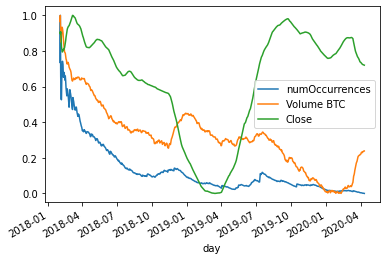

In [65]:
plot_df = join_df[join_df['year'].isin([2018,2019,2020])].copy()
for col in ['Close', 'numOccurrences', 'Volume BTC']:
    if col in ['Close', 'Volume BTC']:
        plot_df[col]=plot_df[col].apply(np.log)
    plot_df[col]=plot_df[col].ewm(span = 100).mean()
    plot_df[col]=(plot_df[col]-plot_df[col].min())/(plot_df[col].max()-plot_df[col].min())
plot_df.plot(x="day", y=['numOccurrences','Volume BTC','Close']);

Again, the BTC volume traded and the number of quotes have an analoguous shape.

For the next milestone we will explore these metrics and others further and deeper.